In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ML_Project

/content/drive/.shortcut-targets-by-id/1WNR3o2CO38kvudaWBLsGkvJvMa4hkl39/ML_Project


In [ ]:
%cd /content/drive/MyDrive/ML_Project/learning-to-reweight-examples/

/content/drive/.shortcut-targets-by-id/1WNR3o2CO38kvudaWBLsGkvJvMa4hkl39/ML_Project/learning-to-reweight-examples


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from model import *
from data_loader import *
from data_loader2 import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import gc
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 5})
import numpy as np
import os
import csv

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
hyperparameters = {
    'lr' : 0.1,
    'momentum' : 0.9,
    'batch_size' : 10,
    'num_iterations' : 1000,
}

In [ ]:
data_loader = get_mnist_bkgnd_flip_loader(hyperparameters['batch_size'], mode="train")
test_loader = get_mnist_bkgnd_flip_loader(hyperparameters['batch_size'], mode="test")

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
#data_loader = get_mnist_unif_flip_loader(hyperparameters['batch_size'], mode="train")
#test_loader = get_mnist_unif_flip_loader(hyperparameters['batch_size'], mode="test")

In [ ]:
def to_var(x, requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad)

In [ ]:
val_data = to_var(data_loader.dataset.data_val, requires_grad=False)
val_labels = to_var(data_loader.dataset.labels_val, requires_grad=False)

In [ ]:
print(val_labels.size())

torch.Size([100])


In [ ]:
def build_model():
    net = LeNet(n_out=10)
    if os.path.isfile("mnist_bkgnd_baseline.pt"):
        net.load_state_dict(torch.load('mnist_bkgnd_baseline.pt'))
    if torch.cuda.is_available():
        net.cuda()
        torch.backends.cudnn.benchmark=True

    opt = torch.optim.SGD(net.params(),lr=hyperparameters["lr"])
    
    return net, opt

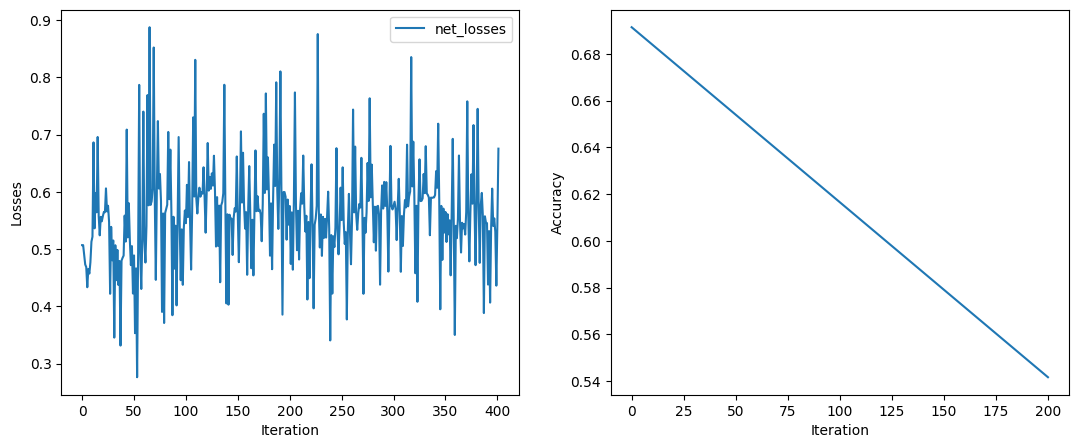

  0%|          | 266/80000 [01:02<5:57:24,  3.72it/s]

In [ ]:
def train_baseline:
  net, opt = build_model()

  net_losses = []
  plot_step = 200
  net_l = 0

  smoothing_alpha = 0.9
  lr_update = 1
  accuracy_log = []
  csv_net_losses = []
  csv_acc = []
  if os.path.isfile("acc_log_baseline_mnist_bknd_flip.csv"):
    with open("acc_log_baseline_mnist_bknd_flip.csv", "r") as csv_file:
      reader = csv.reader(csv_file, delimiter=',')
      for row in reader:
        csv_acc.append(list(np.float_(row)))
    csv_file.close()
    with open("loss_log_baseline_mnist_bknd_flip.csv", "r") as csv_file:
      reader = csv.reader(csv_file, delimiter=',')
      for row in reader:
        csv_net_losses.append(list(np.float_(row)))
    csv_file.close()

  csv_net_losses = np.array(csv_net_losses)
  csv_acc = np.array(csv_acc)
  for i in tqdm(range(iter_start,iter_stop)):
      if i > 40000:
        lr_update = 0.1
      if i > 60000:
        lr_update = 0.01
      opt.param_groups[0]['lr'] = lr_update * hyperparameters['lr']
      net.train()
      image, labels = next(iter(data_loader))

      image = to_var(image, requires_grad=False)
      labels = to_var(labels, requires_grad=False)

      y = net(image)
      cost = F.cross_entropy(y,labels.type(torch.LongTensor).cuda())
      
      opt.zero_grad()
      cost.backward()
      opt.step()
      
      net_l = smoothing_alpha *net_l + (1 - smoothing_alpha)* cost.item()
      net_losses.append(net_l/(1 - smoothing_alpha**(i+1)))
      
      net_losses.append(cost.item())

      if i % plot_step == 0:
          net.eval()
          
          acc = []
          for itr,(test_img, test_label) in enumerate(test_loader):
              test_img = to_var(test_img, requires_grad=False)
              test_label = to_var(test_label, requires_grad=False)
              
              output = net(test_img)
              predicted = torch.argmax(output, dim = 1).int()
              
              acc.append((predicted.int() == test_label.int()).float())

          accuracy = torch.cat(acc,dim=0).mean()
          accuracy_log.append(np.array([i,accuracy.cpu()])[None])
          
          
          IPython.display.clear_output()
          fig, axes = plt.subplots(1, 2, figsize=(13,5))
          ax1, ax2 = axes.ravel()

          net_losses_plot = np.concatenate((csv_net_losses.flatten(),np.array(net_losses)), axis=0) if csv_net_losses.size else np.array(net_losses)
          ax1.plot(net_losses_plot, label='net_losses_baseline')
          ax1.set_ylabel("Losses")
          ax1.set_xlabel("Iteration")
          ax1.legend()
          
          acc_log = np.concatenate((csv_acc,np.concatenate(accuracy_log,axis=0)), axis=0) if csv_acc.size else np.concatenate(accuracy_log,axis=0)
          ax2.plot(acc_log[:,0],100*acc_log[:,1],label='accuracy_reweighted')
          ax2.plot(acc_log[:,0],acc_log[:,1])
          ax2.set_ylabel('Accuracy')
          ax2.set_xlabel('Iteration')
          plt.show()

          torch.save(net.state_dict(), 'mnist_bkgnd_baseline.pt')       
        # return accuracy
          return np.concatenate(accuracy_log, axis=0),net_losses

In [ ]:
iter_start = 0
iter_end = 5000

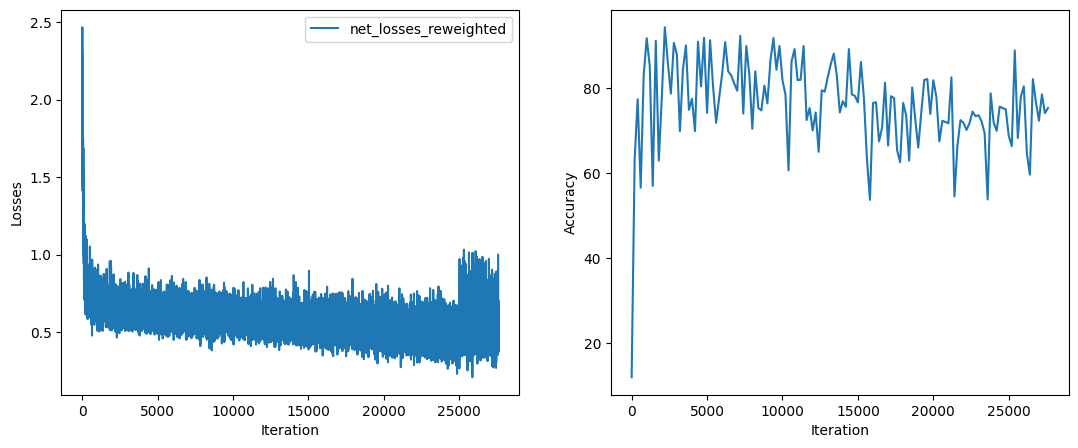

 56%|█████▌    | 2787/5000 [10:27<07:13,  5.11it/s]

In [ ]:
acc_log, net_losses = train_baseline()
with open('acc_log_mnist_bknd_flip.csv','a') as csvfile:
  np.savetxt(csvfile, acc_log, delimiter=',',fmt='%s', comments='')
  csvfile.close()
with open('loss_log_mnist_bknd_flip.csv','a') as csvfile:
  np.savetxt(csvfile, net_losses, delimiter=',',fmt='%s', comments='')
  csvfile.close()